In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm


In [2]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, is_res: bool = False):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        return self.model(x)


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim  # <-- Add this line
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)



In [50]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(8), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 8, 8),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

def forward(self, x, c, t, context_mask):
    x = self.init_conv(x)
    down1 = self.down1(x)
    down2 = self.down2(down1)
    hidden_vec = self.to_vec(down2)

    # Dynamically resize context tensor to match input batch size
    if c.size(0) != x.size(0):
        c = c.repeat((x.size(0) // c.size(0)) + 1)[:x.size(0)]

    # Convert to one-hot encoding and apply context mask
    c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
    context_mask = context_mask[:, None].repeat(1, self.n_classes)
    c = c * (-1 * (1 - context_mask))

    cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
    temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
    cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
    temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

    up1 = self.up0(hidden_vec)
    up2 = self.up1(cemb1 * up1 + temb1, down2)
    up3 = self.up2(cemb2 * up2 + temb2, down1)

    return self.out(torch.cat((up3, x), 1))


In [4]:
def ddpm_schedules(beta1, beta2, T):
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab,
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(self.device)
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w=0.0):
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0, 10).repeat(int(n_sample / 10)).to(device)
        context_mask = torch.zeros_like(c_i).to(device)

        x_i_store = []
        for i in range(self.n_T, 0, -1):
            t_is = torch.tensor([i / self.n_T]).repeat(n_sample, 1, 1, 1).to(device)
            x_i = (
                self.oneover_sqrta[i] * (x_i - self.nn_model(x_i, c_i, t_is, context_mask))
                + self.sqrt_beta_t[i] * torch.randn_like(x_i)
            )
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.cpu().numpy())
        return x_i, np.array(x_i_store)


In [69]:
def evaluate_psnr(ddpm, dataset, device):
    dataloader = DataLoader(dataset, batch_size=10, shuffle=False)
    psnr_values = []

    ddpm.eval()
    for x, _ in dataloader:
        x = x.to(device)
        noise = torch.randn_like(x)
        x_noisy = (
            ddpm.sqrtab[ddpm.n_T, None, None, None] * x
            + ddpm.sqrtmab[ddpm.n_T, None, None, None] * noise
        )

        # Generate context tensor to match batch size
        n_classes = ddpm.nn_model.n_classes
        batch_size = x.size(0)

        # Ensure context tensor matches batch size
        c = torch.arange(0, n_classes).repeat((batch_size // n_classes) + 1)[:batch_size].to(device)

        # Generate reconstructed images
        with torch.no_grad():
            x_reconstructed, _ = ddpm.sample(batch_size, x.size()[1:], device, guide_w=0.0)

        # Calculate PSNR for each image
        for i in range(batch_size):
            psnr_value = psnr(
                x[i].cpu().numpy().transpose(1, 2, 0),
                x_reconstructed[i].cpu().numpy().transpose(1, 2, 0),
                data_range=1.0,
            )
            psnr_values.append(psnr_value)

    # Compute average PSNR
    avg_psnr = np.mean(psnr_values)
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    return avg_psnr


In [62]:
def visualize_images(model, dataloader, num_samples=10):
    model.eval()
    images, noisy_images, reconstructed_images = [], [], []

    with torch.no_grad():
        for batch_images, labels in dataloader:
            batch_images, labels = batch_images.to(device), labels.to(device)
            noise = torch.randn_like(batch_images).to(device)
            t = torch.randint(0, model.n_T, (batch_images.size(0),), device=device).long()

            # Add noise to the original images
            alpha_bar_t = model.sqrtab[t, None, None, None]  # Retrieve alpha_bar at time t
            noisy_batch_images = (
                alpha_bar_t * batch_images
                + model.sqrtmab[t, None, None, None] * noise
            )

            # Predict the noise using the model
            context_mask = torch.zeros_like(labels).to(device)  # No context mask applied here
            predicted_noise = model.nn_model(noisy_batch_images, labels, t / model.n_T, context_mask)

            # Reconstruct the original images from the noisy images and predicted noise
            reconstructed_batch_images = (
                noisy_batch_images - model.sqrtmab[t, None, None, None] * predicted_noise
            ) / alpha_bar_t

            # Append a few samples
            images.extend(batch_images[:num_samples].cpu())
            noisy_images.extend(noisy_batch_images[:num_samples].cpu())
            reconstructed_images.extend(reconstructed_batch_images[:num_samples].cpu())
            break  # Only process the first batch

    # Denormalize and clamp images from [-1, 1] to [0, 1] for visualization
    images = [torch.clamp((img + 1) / 2, 0, 1) for img in images]
    noisy_images = [torch.clamp((img + 1) / 2, 0, 1) for img in noisy_images]
    reconstructed_images = [torch.clamp((img + 1) / 2, 0, 1) for img in reconstructed_images]

    # Enhanced Visualization
    fig, axs = plt.subplots(num_samples, 3, figsize=(6, 2 * num_samples))  # Increased figsize
    for i in range(num_samples):
        # Original Image
        axs[i, 0].imshow(images[i].permute(1, 2, 0).numpy())
        axs[i, 0].set_title("Original Image", fontsize=16)
        axs[i, 0].axis('off')

        # Noisy Image
        axs[i, 1].imshow(noisy_images[i].permute(1, 2, 0).numpy())
        axs[i, 1].set_title("Noisy Image", fontsize=16)
        axs[i, 1].axis('off')

        # Reconstructed Image
        axs[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0).numpy())
        axs[i, 2].set_title("Reconstructed", fontsize=16)
        axs[i, 2].axis('off')

    plt.tight_layout(pad=3.0)  # Adjust padding between subplots
    plt.show()


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_epoch, n_T, n_feat, batch_size, lrate = 20, 400, 128, 256, 1e-4

ddpm = DDPM(ContextUnet(3, n_feat), (1e-4, 0.02), n_T, device).to(device)

tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = CIFAR10("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(ddpm.parameters(), lr=lrate)
for epoch in range(n_epoch):
    ddpm.train()
    epoch_loss = 0
    for x, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = x.to(device)

        # Dynamically create the context tensor
        c = torch.arange(0, 10).repeat(x.size(0) // 10 + 1)[:x.size(0)].to(device)

        loss = ddpm(x, c)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{n_epoch} complete. --- Loss: {loss:.4f}")



100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


100%|██████████| 196/196 [02:10<00:00,  1.50it/s]


Epoch 1/20 complete. --- Loss: 0.0950


100%|██████████| 196/196 [02:09<00:00,  1.51it/s]


Epoch 2/20 complete. --- Loss: 0.0781


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 3/20 complete. --- Loss: 0.0995


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 4/20 complete. --- Loss: 0.0764


100%|██████████| 196/196 [02:12<00:00,  1.48it/s]


Epoch 5/20 complete. --- Loss: 0.0511


100%|██████████| 196/196 [02:09<00:00,  1.51it/s]


Epoch 6/20 complete. --- Loss: 0.0510


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 7/20 complete. --- Loss: 0.0652


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 8/20 complete. --- Loss: 0.0520


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 9/20 complete. --- Loss: 0.0666


100%|██████████| 196/196 [02:08<00:00,  1.52it/s]


Epoch 10/20 complete. --- Loss: 0.0735


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 11/20 complete. --- Loss: 0.0764


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 12/20 complete. --- Loss: 0.0603


100%|██████████| 196/196 [02:08<00:00,  1.52it/s]


Epoch 13/20 complete. --- Loss: 0.0469


100%|██████████| 196/196 [02:09<00:00,  1.51it/s]


Epoch 14/20 complete. --- Loss: 0.0626


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 15/20 complete. --- Loss: 0.0431


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 16/20 complete. --- Loss: 0.0474


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 17/20 complete. --- Loss: 0.0590


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 18/20 complete. --- Loss: 0.0491


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]


Epoch 19/20 complete. --- Loss: 0.0555


100%|██████████| 196/196 [02:09<00:00,  1.52it/s]

Epoch 20/20 complete. --- Loss: 0.0708


Files already downloaded and verified


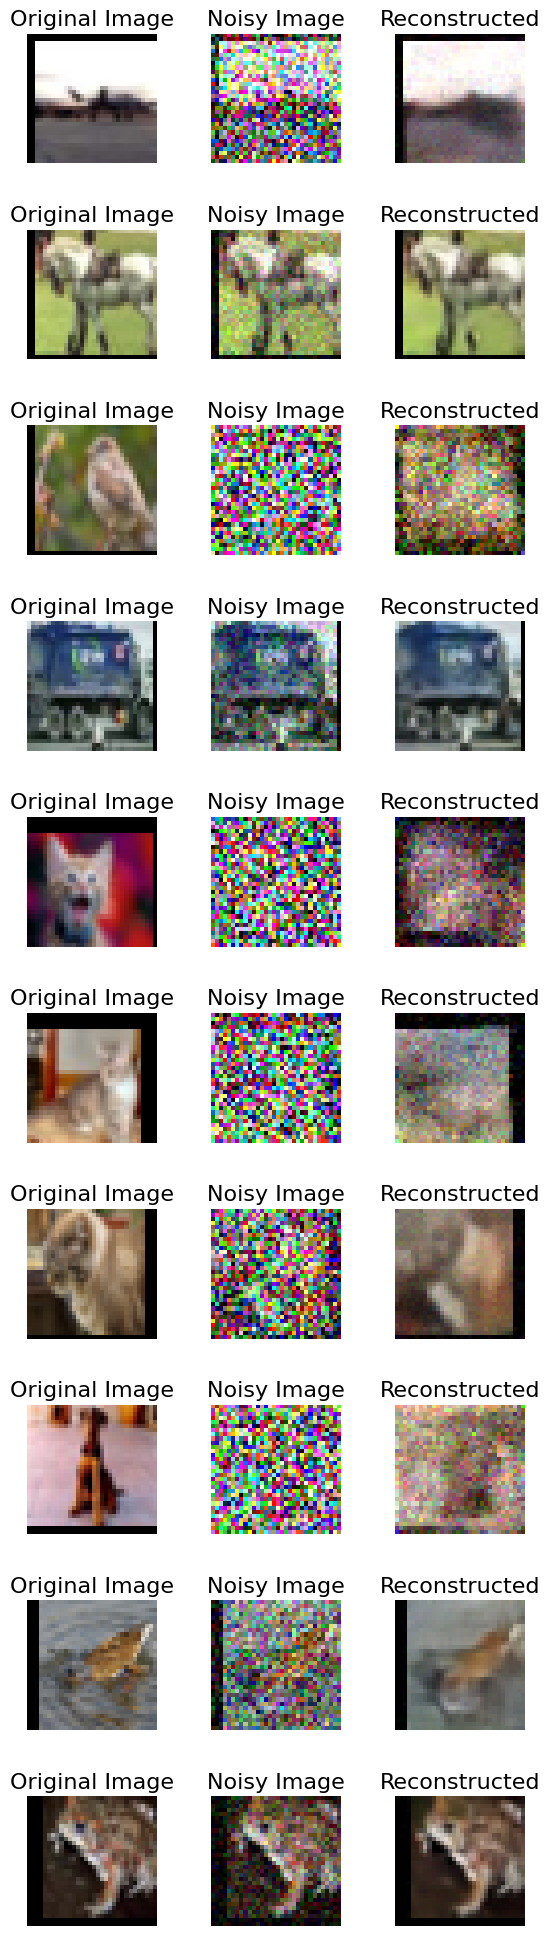

In [65]:
# Ensure dataset is created correctly
tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = CIFAR10("./data", train=True, download=True, transform=tf)

# Wrap the dataset in a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Call visualize_images with the DataLoader
visualize_images(ddpm, dataloader, num_samples=10)


In [71]:
avg_psnr = evaluate_psnr(ddpm, dataset, device)
print(f"Final Average PSNR: {avg_psnr:.2f} dB")

Final Average PSNR: 21.3 dB
